In [18]:
import contextily as cx
import geopandas as gpd
import geoplot
import geoplot.crs as gcrs
import matplotlib.pyplot as plt
import pandas as pd
import sys
sys.path.append('../utils')
from helper_functions import combine_zip_codes_and_county_geos, total_vehicles_by_zip, city_geos

In [3]:
# Get a mapping of California zip codes to counties
# This also includes 2017 population
zip_code_path = "../geojsons/California_Zip_Codes.geojson"
counties_path = "../geojsons/California_County_Boundaries.geojson"
zip_county_mapper = combine_zip_codes_and_county_geos(zip_code_path, counties_path)[['zip_code', 'po_name', 'population', 'county_name', 'county_abbrev']]
zip_county_mapper.rename(columns = {'population': 'pop_2017'}, inplace = True)
zip_county_mapper.pop_2017 = zip_county_mapper.pop_2017.astype(str)

Reading in geojson files...
California has 1721 zip codes and 69 counties
Our join lost us 4 zip codes out of 1721


,zip_code,po_name,pop_2017,county_name,county_abbrev
0,00012,Mt Meadows Area,-99,Lassen,LAS
4,00019,Lassen Ntl Forest,-99,Lassen,LAS
1654,96056,McArthur,2670,Lassen,LAS
1686,96109,Doyle,994,Lassen,LAS
1689,96113,Herlong,2080,Lassen,LAS


In [4]:
# Get California 2021 population
pop_2021 = pd.read_csv('../vehicle_data/california_pop_by_zip_code.csv', thousands=',')[['zip_code', 'population_2021']]
pop_2021.rename(columns = {'population_2021': 'pop_2021'}, inplace = True)
pop_2021 = pop_2021.astype({'zip_code': 'str', 'pop_2021': 'int64'})

zip_code    object
pop_2021     int64
dtype: object

In [5]:
zip_county_mapper_final = zip_county_mapper.merge(pop_2021, on='zip_code', how='left')

In [6]:
# Read in county geojson - we will use this for plotting
counties = gpd.read_file(counties_path)
counties.columns= counties.columns.str.lower()

# Dedupping columns. There are multiple instances of slightly different geometries for:
# Los Angeles, Santa Barbara, and Ventura Counties
counties['rank'] = counties.groupby('county_name')['objectid'].rank(method='first')
counties = counties[counties['rank'] == 1]

In 2018 vs 2022 - how many vehicles are there per capita overall? Per county?

In [8]:
# Read in vehicle counts information
vehicles_by_zip_2018 = total_vehicles_by_zip('../vehicle_data/vehicle-fuel-type-count-by-zip-code.csv')
vehicles_by_zip_2022 = total_vehicles_by_zip('../vehicle_data/vehicle-fuel-type-count-by-zip-code-2022.csv')

In [9]:
zip_county_vehicles = zip_county_mapper_final.merge(vehicles_by_zip_2018, 
                                                    on='zip_code', 
                                                    how = 'left')
zip_county_vehicles.rename(columns = {'vehicles': 'vehicles_2018'}, inplace = True)

zip_county_vehicles = zip_county_vehicles.merge(vehicles_by_zip_2022, 
                                                on='zip_code', 
                                                how = 'left')
zip_county_vehicles.rename(columns = {'vehicles': 'vehicles_2022'}, inplace = True)

In [11]:
# Process data anomalies
# Some zip codes have no reported vehicles reported as NaN - we'll replace these with 0s
# Some zip codes (such as national forests or parks) have no population recorded with -99 as the flag for this. 
# We'll convert this to 0s as well
county_info = zip_county_vehicles[['county_name', 'pop_2017', 'pop_2021', 'vehicles_2018', 'vehicles_2022']]
county_info = county_info.fillna(0)
cols_to_convert = ['pop_2017', 'pop_2021', 'vehicles_2018', 'vehicles_2022']
county_info[cols_to_convert] = county_info[cols_to_convert].astype(int)
county_info['pop_2017'] = county_info['pop_2017'].clip(lower=0)

In [12]:
# Sum up all zip code populations and vehicles within a county
county_info = county_info.groupby(['county_name'])[cols_to_convert].sum().reset_index()

In [13]:
# subset county gdf to only get county name and geometry
county_geoms = counties[['county_name', 'geometry']]

In [14]:
# merge county population and vehicle info with geometries
county_df = county_info.merge(county_geoms, on = 'county_name', how = 'left')

In [15]:
# convert county df to county gdf
county_gdf = gpd.GeoDataFrame(county_df[['county_name', 'pop_2017', 'pop_2021', 'vehicles_2018', 'vehicles_2022']], 
                 geometry=county_df['geometry'])

In [16]:
# Calculate yearly vehicles per capita
county_gdf['vehicles_per_capita_2018'] = county_gdf['vehicles_2018']/county_gdf['pop_2017']
county_gdf['vehicles_per_capita_2022'] = county_gdf['vehicles_2022']/county_gdf['pop_2021']

In [30]:
# set gdf crs to 3857
county_gdf.to_crs(3857, inplace=True)

In [19]:
# Grab city information
cities_path = "../geojsons/City_Boundaries.geojson"
cities = city_geos(cities_path)

Text(0.5, 1.0, 'CA Vehicles per Capita (2022)')

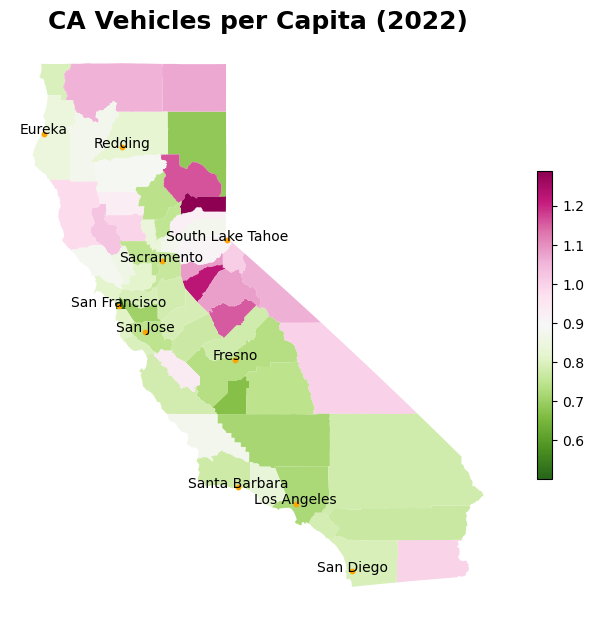

In [45]:
# Plot it!

fig, ax = plt.subplots(figsize = (8, 8))
county_gdf.plot(ax=ax, 
                column='vehicles_per_capita_2022', 
                legend=True, 
                legend_kwds={'shrink':0.5},
                cmap = 'PiYG_r')
cities.plot(ax=ax,
           color = 'orange',
           markersize = 10)

for idx, row in cities.iterrows():
    plt.annotate(text=row['city'], xy=row['coords'], horizontalalignment='center', color='Black')

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

for edge in ['right', 'bottom', 'top','left']:
    ax.spines[edge].set_visible(False)
    
ax.set_title('CA Vehicles per Capita (2022)', size=18, weight='bold')

In [36]:
# Overall stats
california_summary = county_gdf[['pop_2017', 'pop_2021', 'vehicles_2018', 'vehicles_2022']].sum()
vpc_2018 = round(california_summary['vehicles_2018']/california_summary['pop_2017'], 3)
vpc_2022 = round(california_summary['vehicles_2022']/california_summary['pop_2021'], 3)
pct_change = round((vpc_2022-vpc_2018)/vpc_2018*100, 2)

print(f'Overall, California had {vpc_2018} vehicles per person in 2018 and {vpc_2022} in 2022')
print(f"That's a total percent change of {pct_change}%")

Overall, California had 0.759 vehicles per person in 2018 and 0.762 in 2022
That's a total percent change of 0.4%


In [37]:
# Counties with the lowest vpc in 2022
county_gdf.sort_values(by=['vehicles_per_capita_2022']).head(5)

,county_name,pop_2017,pop_2021,vehicles_2018,vehicles_2022,geometry,vehicles_per_capita_2018,vehicles_per_capita_2022
37,San Francisco,840385,836226,439226,419435,"MULTIPOLYGON (((-13622595.330 4563001.785, -13...",0.522649,0.501581
15,Kings,151322,149528,95132,100245,"MULTIPOLYGON (((-13305877.633 4360024.454, -13...",0.628673,0.670410
17,Lassen,28608,27874,18905,19100,"MULTIPOLYGON (((-13358317.884 5039557.911, -13...",0.660829,0.685226
0,Alameda,1657674,1690090,1220624,1191432,"MULTIPOLYGON (((-13611173.233 4566017.932, -13...",0.736347,0.704952
14,Kern,861290,864788,585871,618946,"MULTIPOLYGON (((-13094892.195 4272697.577, -13...",0.680225,0.715720


In [38]:
# Counties with the highest vpc in 2022
county_gdf.sort_values(by=['vehicles_per_capita_2022'], ascending = False).head(5)

,county_name,pop_2017,pop_2021,vehicles_2018,vehicles_2022,geometry,vehicles_per_capita_2018,vehicles_per_capita_2022
45,Sierra,3659,3380,4441,4354,"MULTIPOLYGON (((-13374730.421 4823568.308, -13...",1.213720,1.288166
4,Calaveras,43649,42709,51444,52135,"MULTIPOLYGON (((-13360333.217 4641182.754, -13...",1.178584,1.220703
31,Plumas,24277,24718,29228,28666,"MULTIPOLYGON (((-13506096.484 4930869.043, -13...",1.203938,1.159722
21,Mariposa,18026,17394,20587,20089,"MULTIPOLYGON (((-13281469.361 4548145.821, -13...",1.142073,1.154938
2,Amador,36396,38650,40957,41884,"MULTIPOLYGON (((-13366405.546 4679183.529, -13...",1.125316,1.083674


In [39]:
# Incorporate pct_change in vpc for each county
county_gdf['vpc_pct_change'] = ((county_gdf['vehicles_per_capita_2022'] - county_gdf['vehicles_per_capita_2018'])/
                                county_gdf['vehicles_per_capita_2018'])*100
county_gdf.head()

,county_name,pop_2017,pop_2021,vehicles_2018,vehicles_2022,geometry,vehicles_per_capita_2018,vehicles_per_capita_2022,vpc_pct_change
0,Alameda,1657674,1690090,1220624,1191432,"MULTIPOLYGON (((-13611173.233 4566017.932, -13...",0.736347,0.704952,-4.263698
1,Alpine,901,1061,983,1068,"MULTIPOLYGON (((-13312326.921 4680816.110, -13...",1.091010,1.006598,-7.737091
2,Amador,36396,38650,40957,41884,"MULTIPOLYGON (((-13366405.546 4679183.529, -13...",1.125316,1.083674,-3.700469
3,Butte,228784,217125,175845,161150,"MULTIPOLYGON (((-13478186.664 4807593.081, -13...",0.768607,0.742199,-3.435810
4,Calaveras,43649,42709,51444,52135,"MULTIPOLYGON (((-13360333.217 4641182.754, -13...",1.178584,1.220703,3.573713


Text(0.5, 1.0, 'CA Vehicles per Capita Pct. Change from 2018 to 2022')

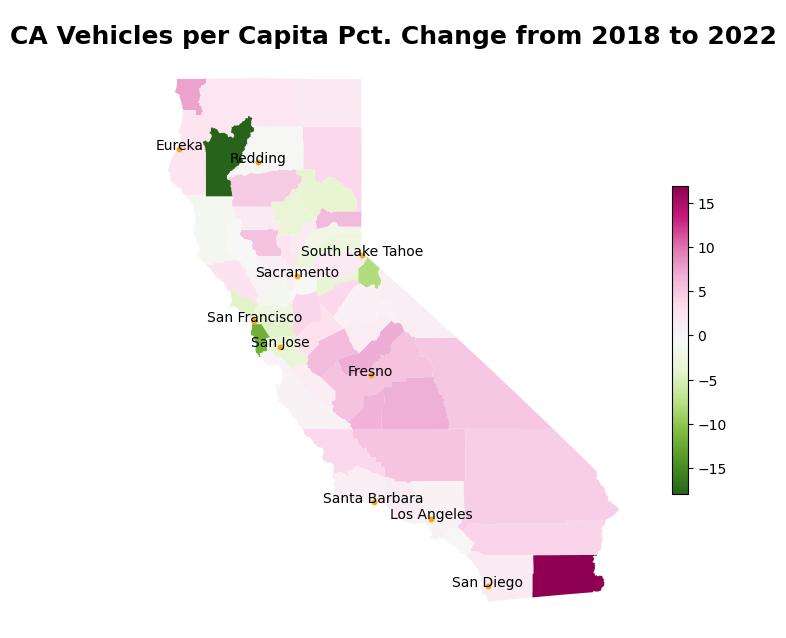

In [46]:
fig, ax = plt.subplots(figsize = (8, 8))
county_gdf.plot(ax=ax, 
                column='vpc_pct_change', 
                legend=True, 
                legend_kwds={'shrink':0.5},
                cmap = 'PiYG_r')

cities.plot(ax=ax,
           color = 'orange',
           markersize = 10)

for idx, row in cities.iterrows():
    plt.annotate(text=row['city'], xy=row['coords'], horizontalalignment='center', color='Black')

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

for edge in ['right', 'bottom', 'top','left']:
    ax.spines[edge].set_visible(False)
    
ax.set_title('CA Vehicles per Capita Pct. Change from 2018 to 2022', size=18, weight='bold')

## Makes analysis

In [ ]:
# Fuel type dictionary:
fuel_dict = {'Battery Electric': 'ZEV',
            'Diesel and Diesel Hybrid': 'Fuel',
            'Flex-Fuel': 'Fuel',
            'Gasoline': 'Fuel',
            'Hybrid Gasoline': 'Hybrid',
            'Hydrogen Fuel Cell': 'ZEV',
            'Natural Gas': 'Fuel',
            'Other': 'Fuel',
            'Plug-in Hybrid': 'Hybrid'
}
raw['fuel (broad)'] = raw['fuel'].map(fuel_dict)
raw['fuel (broad)'].unique()

In [ ]:
raw_newest = raw[raw['model year'].isin(['2022', '2021', '2020'])]
raw_newest[raw_newest['fuel (broad)'] != 'Fuel'].groupby('make')['vehicles'].sum()

In [ ]:
raw_newest['vehicles'].sum()